# Effects of Gender,Age,Bike Sharing & Membership on Ford Go Bike Trips Duration & Distance

## The Investigation Overview

In this investigation, I wanted to look at the characteristics that affect distance and duration of bike trips by ford service. The main focus was on the four categorical entities :Gender , Age, Membership, Bike Sharing feature


## Dataset Overview

The data consisted of prices and attributes of approximately 183,411 ford go bike trips . The Categorical Features included Membership,Gender,start station name,end station name and bike sharing feature as well as numerical Features such Duration, Start station longitude and latitude, End Station longitude and latitude and member birth year 16,623 points(rows) were removed from the analysis due to inconsistencies or missing information and distance was calculated from longitude and latitude.

In [1]:
#installing rise for presentation
!pip install RISE

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from pandas_profiling import ProfileReport
import warnings
from scipy import stats
import plotly.offline as pyo
import plotly.express as px
warnings.simplefilter("ignore")




%matplotlib inline

In [3]:
# load in the dataset into a pandas dataframe, print statistics
df = pd.read_csv('201902-fordgobike-tripdata.csv')

In [4]:
#Data Wrangling

#calculating distance based on longitude and lattitude and saving them in a new column called distance
x1=df["start_station_latitude"]
y1=df["start_station_longitude"]
x2=df["end_station_latitude"]
y2=df["end_station_longitude"]
z = x2 - x1
f = (y2 - y1) * np.cos((x2 + x1)*0.00872664626)
df["distance"]=111.319 * np.sqrt(z*z + f*f)

#excluding unwanted columns
del df["start_time"]
del df["end_time"]
del df["start_station_latitude"]
del df["start_station_longitude"]
del df["end_station_latitude"]
del df["end_station_longitude"]

#Dropping Nan Values
df=df.dropna()

#zeros percentage is small we can drop rows with 0 values in distance  and less than 1950 in birthyear in order not to bias our investigation
df = df[(df.distance > 0)]
df= df[(df.member_birth_year >= 1950 )]

#first we create a new df with columns that we want to exclude outliers from
col=['duration_sec','distance','member_birth_year']

#excluding outliers using zscore and checking new data after outliers drop
df=df[(np.abs(stats.zscore(df[col])) < 3).all(axis=1)]

# converting start_station_name, end_station_name, user_type and member_gender into categorical types
df['start_station_name'] = pd.Categorical(df.start_station_name)
df['end_station_name'] = pd.Categorical(df.end_station_name)
df['user_type'] = pd.Categorical(df.user_type)
df['member_gender'] = pd.Categorical(df.member_gender)
df['bike_share_for_all_trip'] = pd.Categorical(df.bike_share_for_all_trip)

#adding log_duration to our df
df['log_duration']=np.log(df.duration_sec)

#creating age group categories and adding them to our df
bins= [1956,1980,1987,1992,2002]
labels = ['63-40','39-33','32-28','27-19']
df['AgeGroup'] = pd.cut(df['member_birth_year'], bins=bins, labels=labels, right=False)

## Distribution of Durations

duration has a long-tailed distribution, with a lot of durations on the low duration end, and few on the high duration end. When plotted on a log-scale, the duration distribution looks roughly the same but more distributed around between the 100 - 2000 range with most of the values being between 100-1500 there is a smooth ramp down after the 700 mark

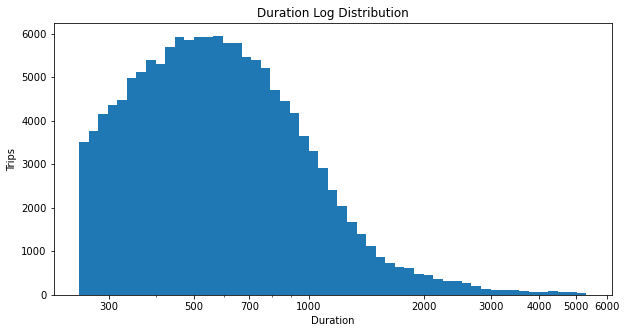

In [5]:
# plotting log of duration
log_binsize = 0.025
bins = 10 ** np.arange(2.4, np.log10(df['duration_sec'].max())+log_binsize, log_binsize)
plt.figure(figsize=[10, 5])
plt.hist(data = df, x = 'duration_sec', bins = bins)
plt.xscale('log')
plt.xticks([3e2,5e2,7e2,1e3,2e3,3e3,4e3,5e3,6e3], ['300','500','700','1000','2000','3000','4000','5000','6000'])
plt.xlabel('Duration')
plt.ylabel('Trips')
plt.title('Duration Log Distribution')
plt.show()

# Distribution of Distance

In the case of distance, the distance seems to be around the mean and to spike at 1 and 2 and 1.5 km and seem to decline after the 1.3km mark smoothly

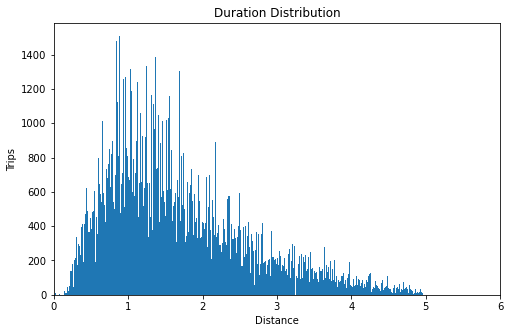

In [6]:
# investigating Distribution of ditance
binsize = 0.01
bins = np.arange(0, 6, 0.01)
plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'distance', bins = bins)
plt.xlim([0,6])
plt.xlabel('Distance')
plt.ylabel('Trips')
plt.title('Duration Distribution')
plt.show()

## Comparison Between Distance & Duration

As suspected distance and duration correlate strongly as whenever distance increase duration increase ( this graph was done between distance and the log transformation of duration ) specially after the 0.3 km mark

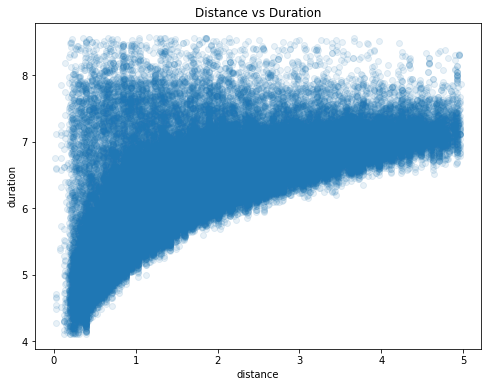

In [7]:
#Plotting Distance vs Duration(log)
plt.figure(figsize = [8, 6])
plt.scatter(data = df, x = 'distance', y = 'log_duration', alpha = 1/10)
plt.xlabel('distance')
plt.ylabel('duration')
plt.title('Distance vs Duration')
plt.show()

## Duration & Distance by BikeSharing Feature

In case of bike sharing there a strong correlation in case of distance but a weaker one with duration 

In [8]:
#setting a custom pallete that highlight max value
def set_custom_palette(series, max_color = 'turquoise', other_color = 'lightgrey'):
    max_val = series.max()
    pal = []
    
    for item in series:
        if item == max_val:
            pal.append(max_color)
        else:
            pal.append(other_color)
    return pal

#grouping bike share feature with avg of numerical values
dfgrouped2= df.groupby('bike_share_for_all_trip').mean().reset_index()

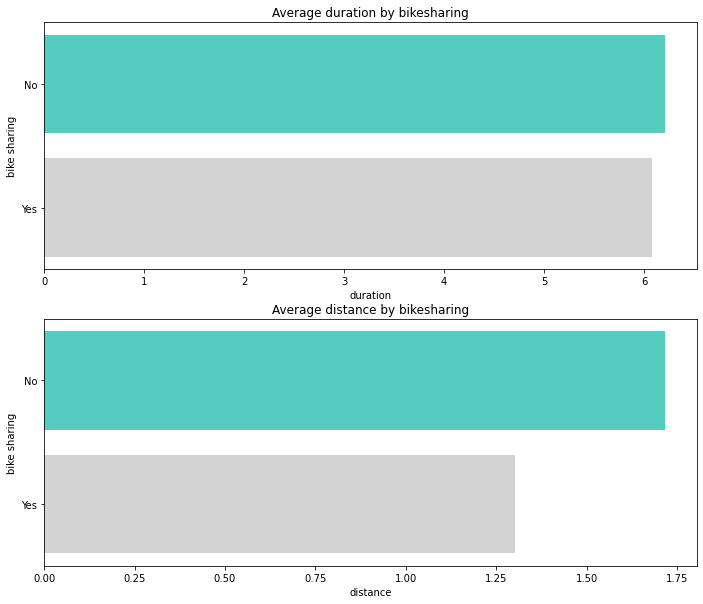

In [9]:
# plotting distance and duration vs bike sharing feature
plt.figure(figsize=(11.69,10))

plt.subplot(2, 1, 1)
ax = sb.barplot(x = 'log_duration', y = 'bike_share_for_all_trip', data=dfgrouped2,palette=set_custom_palette(dfgrouped2['log_duration']))
ax.set_title('Average duration by bikesharing')
ax.set(xlabel='duration', ylabel= 'bike sharing');

ax = plt.subplot(2, 1, 2)
ax = sb.barplot(x = 'distance', y = 'bike_share_for_all_trip', data=dfgrouped2,palette=set_custom_palette(dfgrouped2['distance']))
ax.set_title('Average distance by bikesharing')
ax.set(xlabel='distance', ylabel= 'bike sharing');
 
plt.show()

## Duration&Distance by Membership Type for Gender

In this case of customers who are males there is a tendency for duration and time to increase same for female customers and there is an abnormality in the distribution in case of others but with a tendency to follow the correlation

In [10]:
def hist2dgrid(x, y, **kwargs):
    """ Quick hack for creating heat maps with seaborn's PairGrid. """
    palette = kwargs.pop('color')
    bins=20
    plt.hist2d(x, y, bins = bins, cmap = palette, cmin = 0.5)

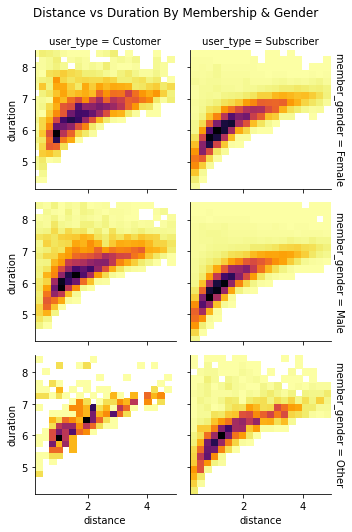

In [11]:
# create faceted heat maps on user types and gender
g = sb.FacetGrid(data = df, col = 'user_type', row = 'member_gender', size = 2.5,margin_titles = True)

g.map(hist2dgrid, 'distance', 'log_duration', color = 'inferno_r')
g.set_xlabels('distance')
g.set_ylabels('duration')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Distance vs Duration By Membership & Gender')

plt.show()

## Effect of Gender, Agegroup & User Type By  Bike Sharing Feature

1- being a male subscriber with the bike sharing feature and between age group 27-19 and 32-28 (majority) decreases duration and distance

2- being a male customer with no bike sharing feature seems to increase duration by a margin regardless of age group

3- being a female subscriber with bike sharing feature does decrease duration and distance regardless of age group

4- being a female customer without bike sharing feature seems to increase duration and distance regardless of age group

in summary there seems to be a correlation between all 4 categories and duration and data but since our categorical data is not ordinal we cannot define if it is a positive or negative one it is more of a specific type correlation


In [12]:
#minimizing duration by using cuberoot of duration for visualization
df['cube_duration']=np.cbrt(df.duration_sec)

In [13]:
#tree mapping distance with all our 4 categories
df['union']='all'
fig = px.treemap(df, path=['union','member_gender','user_type','bike_share_for_all_trip','AgeGroup'], values='cube_duration',
                  color='distance',
                  color_continuous_scale='RdBu',title='Distance by Duration Distribution Over Our 4 Categorical Variable')
fig.show()

In [14]:
#tree mapping duration with all our 4 categories
fig = px.treemap(df, path=['union','member_gender','user_type','bike_share_for_all_trip','AgeGroup'], values='distance',
                  color='cube_duration',
                  color_continuous_scale='RdBu'
                ,title='Duration by Distance Distribution Over Our 4 Categorical Variable')
fig.show()

In [15]:
!jupyter nbconvert Ford_Slide_Show.ipynb --to slides --no-input

[NbConvertApp] Converting notebook Ford_Slide_Show.ipynb to slides
[NbConvertApp] Writing 484898 bytes to Ford_Slide_Show.slides.html
